In [1]:
import sys
sys.path.append('./models/')
from Model import Model
from Arima import ARIMA_Model, VAR_m
from exponential_regression import ExponentialRegression, MultiDimensionalExponentialRegression
from SIRH  import *
from LinearRegression import *
from BayesianRegression import *
from moving_average import MovingAverage, MovingAverageMulti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evaluate_model import evaluate_model, evaluate_model_multi, evaluate_model_multi_RMSE, evaluate_model_RMSE
import json
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [2]:
#For plotting lines with colour gradients
from collections import deque
from itertools import islice
from matplotlib import collections as mc
from matplotlib.colors import colorConverter

In [3]:
def sliding_window(iterable, n):
  """
  sliding_window('ABCDEFG', 4) -> ABCD BCDE CDEF DEFG
  
  recipe from python docs
  """
  it = iter(iterable)
  window = deque(islice(it, n), maxlen=n)
  if len(window) == n:
      yield tuple(window)
  for x in it:
      window.append(x)
      yield tuple(window)

In [4]:
def color_gradient(x, y, c1, c2):
  """
  Creates a line collection with a gradient from colors c1 to c2,
  from data x and y.
  """
  n = len(x)
  if len(y) != n:
    raise ValueError('x and y data lengths differ')
  return mc.LineCollection(sliding_window(zip(x, y), 2),
                           colors=np.linspace(colorConverter.to_rgb(c1),
                                              colorConverter.to_rgb(c2), n - 1))

In [5]:
df=pd.read_csv('hopitalized_and_infectious.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
n_hospitalized=np.array(df['hospitalized'])
n_infectious=np.array(df['n_infectious'])


In [6]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility_bis.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)
mobility=np.array(df_mobility['mobility'])
data3D=np.array([n_hospitalized, n_infectious, mobility])

In [7]:
#Processing of mobility data
relier_les_points=[]
for i in range(len(mobility)): 
    if i + 7 < len(mobility): 
        if i % 7 ==0:
            relier_les_points.append(mobility[i])
        else: 
            decalage=i-7*(i//7)
            res = (1-decalage/7)*mobility[7*(i//7)] + (decalage/7)*mobility[7*(i//7)+7]

            relier_les_points.append(res)
    else:
        relier_les_points.append(mobility[i])
mobility_smoothed=np.array(relier_les_points)


In [8]:
alpha=0.05 #Confidence interval at 100(1-alpha)%

myma=MovingAverage()
myarima=ARIMA_Model()
mybayes=BayesianRegressionModel()
mylinear=LinearRegressionModel()
myvar=VAR_m()

myexp=ExponentialRegression()
myexpmulti=MultiDimensionalExponentialRegression()

mysirh1=SIRH_model_2()
mysirh1.choose_model(True, True, False)
mysirh2=SIRH_model_2()
mysirh2.choose_model(True, False, False)
mysirh3=SIRH_model_2()
mysirh3.choose_model(False, True, False)
mysirh4=SIRH_model_2()
mysirh4.choose_model(False, False, False)

mysirh_multi1=Multi_SIRH_model()
mysirh_multi1.choose_model(True)

mysirh_multi2=Multi_SIRH_model()
mysirh_multi2.choose_model(False)

myseir=SEIR_model()

In [9]:
def generate_prediction(model: Model, data: np.array, alpha: int, start: int, horizon: int, threeD: bool):
    if threeD:
        n_hospitalized_trunc=data[0][:start]
        n_infectious_trunc=data[1][:start]
        mobility_smoothed_trunc=data[2][:start]
        model.train(train_dates = [i for i in range(start)], data = np.array([n_hospitalized_trunc, n_infectious_trunc, mobility_smoothed_trunc]))
    else:
        n_hospitalized_trunc=data[0][:start]
        model.train(train_dates = [i for i in range(start)], data=n_hospitalized_trunc)
    #intervals=[]
    #reach=[i for i in range(1, horizon)]
    #predict=[]
    prediction, interval = model.predict(horizon, alpha)
    return interval, prediction

11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291


/opt/anaconda3/lib/python3.11/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


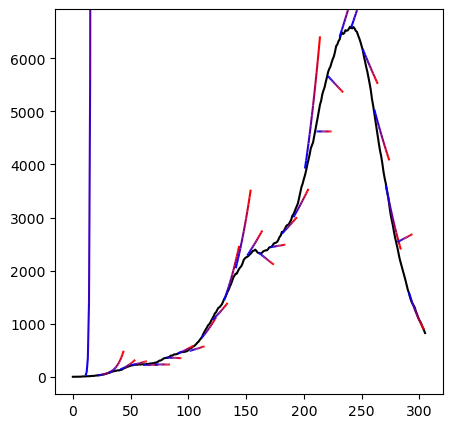

In [10]:
start_dates=[(1+10*i) for i in range(1,30)]
#start_dates=[11]
horizon=14
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(n_hospitalized,'k')
for S in start_dates:
    print(S)
    CI, predict=generate_prediction(model=myexpmulti, data=data3D, alpha=alpha, start=S, horizon=horizon,threeD=True)
    dates=np.arange(S,S+horizon)
    L=color_gradient(dates,predict,'b','r')
    #plt.plot(dates,predict,'r')
    ax.add_collection(L)
#ax.set_xlabel('days')
#plt.ylabel('hospitalised')
plt.savefig('output.pdf')
plt.show()

20
40
60
80
100
120
140
160
180
200
220
240
260
280


/Users/gerlee/Dropbox/Work/Doktorander/Praktikanter/Gregoire/Modellen/covid_internship/./models/exponential_regression.py:159: RuntimeWarning: invalid value encountered in sqrt
  down = scipy.stats.norm.ppf(alpha/2, loc=prediction[i], scale=np.sqrt(varprediction))


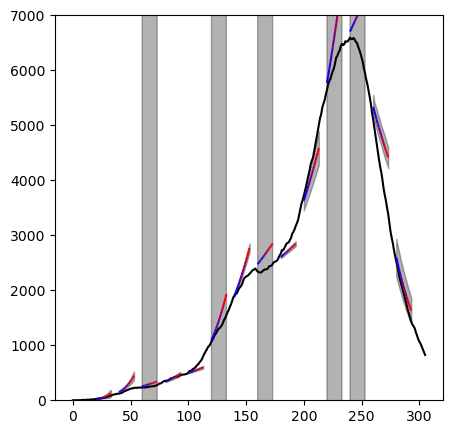

In [13]:
start_dates=[(20*i) for i in range(1,15)]
#start_dates=[100]
horizon=14
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(n_hospitalized,'k')
for S in start_dates:
    print(S)
    CI, predict=generate_prediction(model=myexp, data=data3D, alpha=alpha, start=S, horizon=horizon,threeD=False)
    dates=np.arange(S,S+horizon)
    L=color_gradient(dates,predict,'b','r')
    ci=np.asarray(CI)
    plt.fill_between(dates,ci[0,:], ci[1,:], color='black', alpha=.3, label='95% confidence interval')
    ax.add_collection(L)
#ax.set_xlabel('days')
#plt.ylabel('hospitalised')
plt.savefig('output.pdf')
plt.ylim(0,7000)
plt.show()

In [14]:
print(ci[0,:])

[2253.90354719 2171.68445599 2091.28908288 2014.04994659 1947.46907247
 1868.83285496 1803.81469325 1739.67857021 1671.41904044 1611.22135302
 1552.92939459 1499.24984217 1442.46092149 1389.04792745]
